# Actor Critic Agent

2 neural networks:
- actor - approximates the policy (policy is a probability distribusion that assigns probability to selecting an action given a state)
- critic - calculates the value of the action (given state get the value of the action on the output)

actor and critic share parts of the model (single network with 2 output)


In [1]:
from keras import backend as K 
from keras.layers import  Dense, Input
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from collections import OrderedDict

In [2]:
from environment.fogg_behavioural_model import Patient 

In [3]:
import matplotlib.pyplot as plt

In [4]:
class Agent(object):
    def __init__(self, alpha, beta, gamma=0.99, n_actions =4, layer1_size= 16, layer2_size = 8, input_dim=9 ):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.input_dim =input_dim
        self.fc1_dims = layer1_size
        self.fc2_dims = layer2_size
        self.n_actions = n_actions
        self.actor, self.critic, self.policy = self.build_ac_network()
        self.action_space = [i for i in range(self.n_actions)]
        
    def build_ac_network(self):
        input = Input(shape=(self.input_dim,))
        delta = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='relu')(input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)
        
        
        def custom_loss(y_true, y_pred):
            # we need to take a log of anumber that possible could be 0 we need to do clipping
            out = K.clip(y_pred, 1e-8, 1-1e-8 )
            log_lik = y_true * K.log(out)
            
            return K.sum(-log_lik * delta) # function closer
        
        actor = Model([input, delta], outputs=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        critic = Model([input], outputs=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')
        
        policy = Model([input], outputs=[probs])
        
        return actor, critic, policy
    
    def choose_action(self, observation):
        state = observation[np.newaxis,:]
        probabilities = self.policy.predict(state)[0]
        action = np.random.choice(self.action_space, p=probabilities)
        return action
    
    def learn(self,state, action, reward, state_, done ):
        
        state = state[np.newaxis,:]
        state_ = state_[np.newaxis,:]
        
        critic_value_ = self.critic.predict(state_)
        critic_value = self.critic.predict(state)
        
        target = reward + self.gamma*critic_value_*(1-int(done))
        delta = target - critic_value
        
        #one-hot-encode the actions
        actions = np.zeros([1, self.n_actions])
        actions[np.arange(1), action] = 1.0
        
        self.actor.fit([state, delta], actions, verbose=0)
        self.critic.fit(state, target, verbose=0)
        
        

In [5]:
agent = Agent(alpha = 0.00001, beta= 0.00005)

In [6]:
env = Patient()
env_info = {'behaviour_threshold': 20, 'has_family':True}
env.env_init(env_info)

In [7]:
score_history = []
num_episodes = 100

In [8]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [9]:
for i in range(num_episodes):
    done = False
    score = 0
    observation = env.env_start()
    
    while not done:
        action = agent.choose_action(observation)
        reward, observation_, done, info = env.env_step(action)
        print(info)
        agent.learn(observation, action, reward, observation_, done)
        observation = observation_
        score += reward
    score_history.append(score)
    avg_score = np.mean(score_history[-5:])
    print(score, avg_score)
    

C:\Users\Aneta\anaconda3\envs\rl\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


{'motivation': 1, 'ability': 1, 'trigger': 1, 'action': 1, 'task length': 1, 'reward': -1}
{'motivation': 1, 'ability': 2.0, 'trigger': 2, 'action': 1, 'task length': 1, 'reward': -1}
{'motivation': 2, 'ability': 2.0, 'trigger': 1, 'action': 0, 'task length': 1, 'reward': 0}
{'motivation': 2, 'ability': 2.0, 'trigger': 2, 'action': 1, 'task length': 1, 'reward': -1}
{'motivation': 2, 'ability': 2.0, 'trigger': 1, 'action': 1, 'task length': 1, 'reward': -1}
{'motivation': 2, 'ability': 3.0, 'trigger': 2, 'action': 1, 'task length': 0, 'reward': -1}
{'motivation': 2, 'ability': 2.0, 'trigger': 2, 'action': 1, 'task length': 1, 'reward': -1}
{'motivation': 2, 'ability': 2.0, 'trigger': 2, 'action': 0, 'task length': 1, 'reward': 0}
{'motivation': 2, 'ability': 3.0, 'trigger': 2, 'action': 1, 'task length': 0, 'reward': -1}
{'motivation': 2, 'ability': 2.0, 'trigger': 2, 'action': 0, 'task length': 1, 'reward': 0}
{'motivation': 2, 'ability': 2.0, 'trigger': 2, 'action': 0, 'task length':

KeyboardInterrupt: 

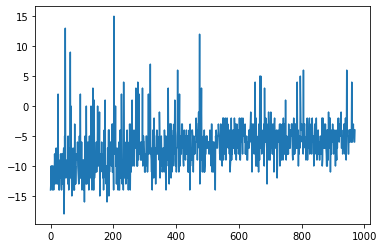

In [13]:
plt.plot(score_history)
plt.show()

In [5]:
from stable_baselines3 import A2C

In [8]:
env.observation_space

Discrete(9)

In [6]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=200)
model.save("a2c_cartpole")

del model # remove to demonstrate saving and loading

model = A2C.load("a2c_cartpole")

score_history = []
observation = env.env_start()
while True:
    action, _states = model.predict(obs)
    reward, observation_, done  =env.env_step(action)
#     env.render()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [9]:
 observation = env.env_start()

In [12]:
from gym import error, spaces

In [13]:
def convert_observation_to_space(observation):
    if isinstance(observation, dict):
        space = spaces.Dict(OrderedDict([
            (key, convert_observation_to_space(value))
            for key, value in observation.items()
        ]))
    elif isinstance(observation, np.ndarray):
        low = np.full(observation.shape, -float('inf'), dtype=np.float32)
        high = np.full(observation.shape, float('inf'), dtype=np.float32)
        space = spaces.Box(low, high, dtype=observation.dtype)
    else:
        raise NotImplementedError(type(observation), observation)

    return space

In [14]:
s = convert_observation_to_space(observation)

In [17]:
s.shape

(9,)

In [18]:
s

Box(-2147483648, -2147483648, (9,), int32)

In [16]:
observation

array([3, 0, 0, 1, 0, 1, 1, 0, 1])

In [20]:
s2 = convert_observation_to_space(np.array([4, 2, 2, 2, 2, 2, 2, 2, 2]))

In [21]:
s2

Box(-2147483648, -2147483648, (9,), int32)

In [22]:
convert_observation_to_space(np.array([1, 1]))

Box(-2147483648, -2147483648, (2,), int32)

In [27]:
d = dict()

d['time_of_the_day'] = np.array(4)
d['day_of_the_week'] =  np.array(2)

# time_of_the_day = 4  # morning, midday, evening, night
        # day_of_the_week = 2  # week day, weekend
        # activity_score = 2  # low/ high
        # location = 2  # home/ other
        # sleeping = 2  # yes/no
        # valence = 2  # positive/negative
        # arousal = 2  # low/high
        # motion = 2  # stationary, walking
        # cognitive_load = 2  # low/ high

In [29]:
s3 = convert_observation_to_space(d)

In [32]:
s3.info

AttributeError: 'Dict' object has no attribute 'info'